# Ejercicio 3: Clasificacion
Empezmo con la carga de datos y paqueteris necesarias

In [19]:
# Cargar las librerías necesarias
using CSV
using DataFrames
using GLMNet
using StatsBase
using MLDataUtils
using ROCAnalysis
using NamedArrays
using EvalMetrics
using Plots

# Cargar el conjunto de datos Smarket
smarket = DataFrame(CSV.File("Smarket.csv"))

# Dividir el conjunto de datos en entrenamiento (2001-2004) y prueba (2005)
train = smarket.Year .< 2005
test = smarket.Year .== 2005
# Preparar los datos para GLMNet
X_train = Matrix(select(smarket[train, :], Not([:Direction, :Year])))
y_train = smarket.Direction[train] .== "Up"
X_test = Matrix(select(smarket[test, :], Not([:Direction, :Year])))
y_test = smarket.Direction[test] .== "Up"
smarket

1250×9 DataFrame
  Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today     ⋯
      │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  2001    0.381   -0.192   -2.624   -1.055    5.01   1.1913     0.959   ⋯
    2 │  2001    0.959    0.381   -0.192   -2.624   -1.055  1.2965     1.032
    3 │  2001    1.032    0.959    0.381   -0.192   -2.624  1.4112    -0.623
    4 │  2001   -0.623    1.032    0.959    0.381   -0.192  1.276      0.614
    5 │  2001    0.614   -0.623    1.032    0.959    0.381  1.2057     0.213   ⋯
    6 │  2001    0.213    0.614   -0.623    1.032    0.959  1.3491     1.392
    7 │  2001    1.392    0.213    0.614   -0.623    1.032  1.445     -0.403
    8 │  2001   -0.403    1.392    0.213    0.614   -0.623  1.4078     0.027
  ⋮   │   ⋮       ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮      ⋱
 1244 │  2005   -0.024   -0.584   -0.285   -0.141    0.419  1.99669    0.252   ⋯
 1245 │  2005    0.252   -0.024   -0.584   -0.285   -0.141  2.06517    0.422
 1246 │  2005    0.422    0.252   -0.024   -0.584   -0.285  1.8885     0.043
 1247 │  2005    0.043    0.422    0.252   -0.024   -0.584  1.28581   -0.955
 1248 │  2005   -0.955    0.043    0.422    0.252   -0.024  1.54047    0.13    ⋯
 1249 │  2005    0.13    -0.955    0.043    0.422    0.252  1.42236   -0.298
 1250 │  2005   -0.298    0.13    -0.955    0.043    0.422  1.38254   -0.489
                                                  1 column and 1235 rows omitted

# LASSO

In [20]:
# Ajustar el modelo de regresión LASSO
lasso_model = glmnet(X_train, y_train, alpha=1)

# Obtener el índice de lambda mínimo
lambda_min_idx = argmin(lasso_model.lambda)

# Obtener las predicciones en el conjunto de prueba usando lambda mínimo
pred_prob = GLMNet.predict(lasso_model, X_test)[:, lambda_min_idx]
pred_class = pred_prob .> 0.5
# Crear la matriz de confusión
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de confusión:")
conf_matrix

Matriz de confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 134 │ 1 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 7 │ 110 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


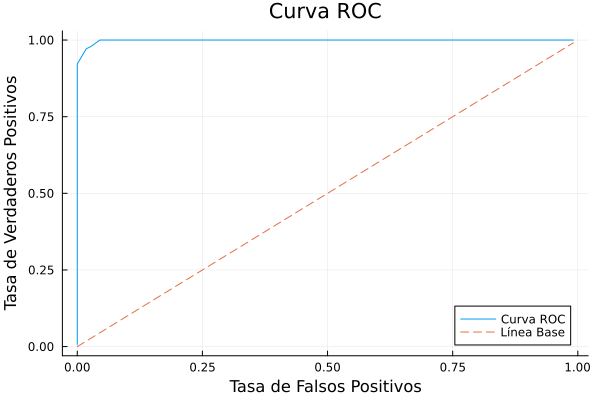

In [21]:
# Función para calcular los puntos de la curva ROC
function calculate_roc(y_true, y_scores; num_thresholds=100)
    thresholds = range(0.0, stop=1.0, length=num_thresholds)
    tpr = zeros(num_thresholds)  # True Positive Rate
    fpr = zeros(num_thresholds)  # False Positive Rate

    for (i, threshold) in enumerate(thresholds)
        tp = sum((y_scores .>= threshold) .& (y_true .== true))
        fp = sum((y_scores .>= threshold) .& (y_true .== false))
        fn = sum((y_scores .< threshold) .& (y_true .== true))
        tn = sum((y_scores .< threshold) .& (y_true .== false))

        tpr[i] = tp / (tp + fn)  # True Positive Rate
        fpr[i] = fp / (fp + tn)  # False Positive Rate
    end

    return fpr, tpr
end

# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Podemoss ver tanto en la matriz de confucion como en la curva ROC que las predicciones no son perfectas pero tienen un alto nivel de  exactitud

# Ridge

In [22]:
# Ajustar el modelo de regresión LASSO
lasso_model = glmnet(X_train, y_train, alpha=0)

# Obtener el índice de lambda mínimo
lambda_min_idx = argmin(lasso_model.lambda)

# Obtener las predicciones en el conjunto de prueba usando lambda mínimo
pred_prob = GLMNet.predict(lasso_model, X_test)[:, lambda_min_idx]
pred_class = pred_prob .> 0.5
# Crear la matriz de confusión
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de confusión:")
conf_matrix

Matriz de confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 135 │ 1 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 6 │ 110 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


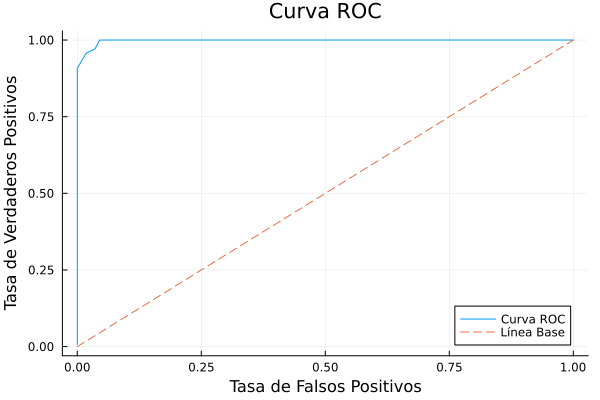

In [23]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Con este algoritmo pasa lo mismo que en el anterior, realmente las diferencias son insignificantes

# Elastic Net

In [24]:
lasso_model = glmnet(X_train, y_train, alpha=0.5)

# Obtener el índice de lambda mínimo
lambda_min_idx = argmin(lasso_model.lambda)

# Obtener las predicciones en el conjunto de prueba usando lambda mínimo
pred_prob = GLMNet.predict(lasso_model, X_test)[:, lambda_min_idx]
pred_class = pred_prob .> 0.5
# Crear la matriz de confusión
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de confusión:")
conf_matrix

Matriz de confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 134 │ 1 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 7 │ 110 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


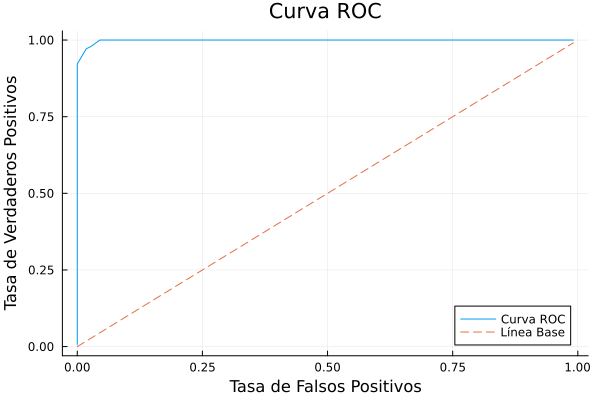

In [25]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Los mismos resultados en en el algoritmo de LASSO

# Decision Tree

In [26]:
using DecisionTree
# Ajustar el modelo de Decision Tree
model = DecisionTreeClassifier(max_depth=5)
DecisionTree.fit!(model, X_train, y_train)

# Obtener las predicciones en el conjunto de prueba
pred_prob = DecisionTree.predict(model, X_test)
pred_class = pred_prob .> 0.5
# Calcular la matriz de confusión
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de Confusión:")
conf_matrix

Matriz de Confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 141 │ 0 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 0 │ 111 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


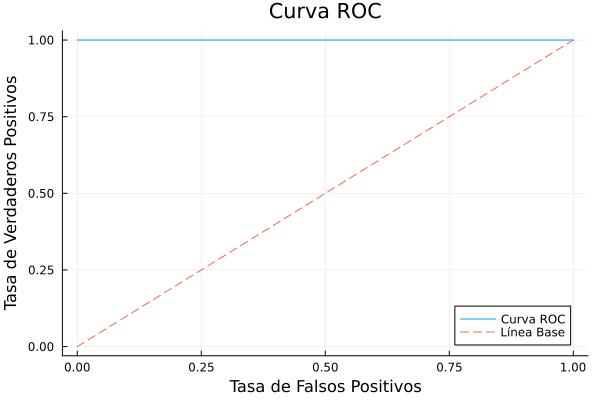

In [27]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

El primer algoritmo con una exactitud total, sin ningun error

#  Random Forest

In [28]:
# Ajustar el modelo de Random Forest
model = RandomForestClassifier(n_trees=100, max_depth=5)
DecisionTree.fit!(model, X_train, y_train)

# Obtener las predicciones en el conjunto de prueba
pred_prob = predict_proba(model, X_test)[:, 2]  # Probabilidad de clase positiva
pred_class = DecisionTree.predict(model, X_test)
# Calcular la matriz de confusión
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de Confusión:")
conf_matrix

Matriz de Confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 141 │ 0 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 0 │ 111 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


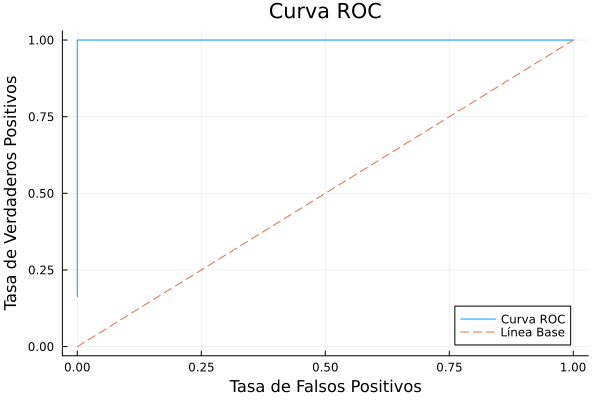

In [29]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Al igual que los arboles de decision demuesyran ser muy efectivos

# Nearest Neighbors

In [30]:
using NearestNeighbors
# Ajustar el modelo de vecinos más cercanos
k = 3  # Número de vecinos
knn_model = KDTree(X_train)

# Realizar predicciones en el conjunto de prueba
function predict_knn_prob(knn_model, X_train, y_train, X_test, k)
    probabilities = []
    for i in 1:size(X_test, 1)
        # Encontrar los k vecinos más cercanos
        idxs, _ = knn(knn_model, X_test[i, :], k)
        # Obtener las etiquetas de los vecinos
        neighbor_labels = y_train[idxs]
        # Calcular la probabilidad de que la etiqueta sea "Up"
        prob_up = sum(neighbor_labels) / k
        push!(probabilities, prob_up)
    end
    return probabilities
end

function predict_knn(knn_model, X_train, y_train, X_test, k)
    predictions = []
    for i in 1:size(X_test, 1)
        # Encontrar los k vecinos más cercanos
        idxs, _ = knn(knn_model, X_test[i, :], k)
        # Obtener las etiquetas de los vecinos
        neighbor_labels = y_train[idxs]
        # Predecir la etiqueta más común entre los vecinos
        push!(predictions, sum(neighbor_labels) >= k/2)
    end
    return predictions
end

pred_class = predict_knn(knn_model, X_train, y_train, X_test, k)
y_prob = predict_knn_prob(knn_model, X_train, y_train, X_test, k)
conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de Confusión:")
conf_matrix

Matriz de Confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 138 │ 111 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 3 │ 0 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


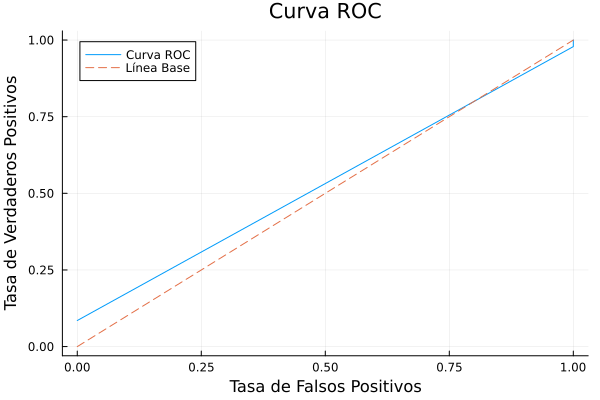

In [31]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, y_prob)

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

En este caso no estoy muy seguro de los resultados o del procedimiento sea exacto pero al parcer este algoritmo no es muy efectivo, parece que obtuvimos resultados aleatorios

# Support Vector Machines (SVM)

In [32]:
using LIBSVM
# Entrenar el modelo SVM
model = svmtrain(X_train', y_train)
# Predicciones
pred_class, pred_prob = svmpredict(model, X_test')

conf_matrix = ConfusionMatrix(y_test, pred_class)
println("Matriz de Confusión:")
conf_matrix

Matriz de Confusión:


┌────────────┬───────────┬───────────┐
│ Tot = 252  │ Actual │ Actual │
│            │ positives │ negatives │
├────────────┼───────────┼───────────┤
│ Prediced │ 139 │ 5 │
│ positives │           │           │
├────────────┼───────────┼───────────┤
│ Prediced │ 2 │ 106 │
│ negatives │           │           │
└────────────┴───────────┴───────────┘


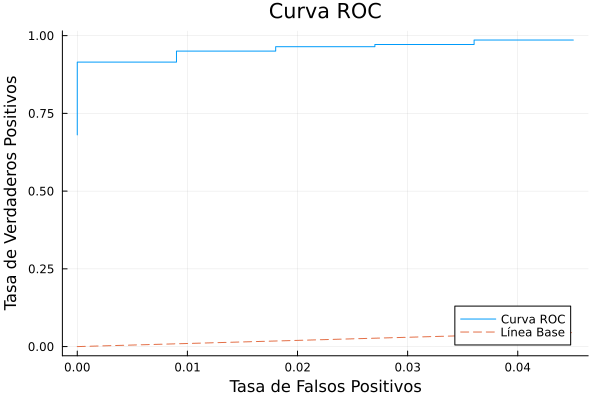

In [33]:
# Calcular los puntos de la curva ROC
fpr, tpr = calculate_roc(y_test, pred_prob[1,:])

# Graficar la curva ROC
plot(fpr, tpr, label="Curva ROC", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", title="Curva ROC")
plot!(x -> x, label="Línea Base", linestyle=:dash)

Buenas predicciones, no tanto como los arboles de decision pero si mejores que LASSO y Ridge